# On IPM algorithms

_author: Tyler Coles_

(This is a similar analysis to the one I did for our movement algorithm, 2023-07-20, but this time for IPMs...)

Our disease processing algorithm works on our metapopulations by:

1. Determining the transition events that occur in the aggregate population at a location (locals plus visitors), and 
2. Distributing those events amongst the cohorts present at that location.

In this way, we simulate travelers as well-mixed into their destinations.

The distribution algorithm effectively does sequential multivariate hypergeometric (mvhg) draws against a diminishing pool of individuals, one for each transition event in the compartment model.

If we process events in a fixed order, does this bias our distribution results? What if certain events are much more common than others yet draw from the same source compartment? And what if there is a large disparity in size between the traveling cohorts? Do large event vectors drain the pool of infecteds before smaller events get a chance?

Let's test this experimentally.

## Experiment setup

We'll extract the distribution logic and focus on that, doing just one iteration and one location at a time. By setting up some specific scenarios and re-running the random distribution many times with differing event orders, we can figure out if there is any impact on the probabilities of certain events.

In [1]:
import math
from typing import Callable, Iterable

import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

# Assume an SIRH model
# compartments: [S, I, R, H]
# events: [S-I, I-R, I-H, H-R, R-S]
compartments = 4
events = 5
source_compartment_for_event = [0, 1, 1, 3, 2]


def extract_last_I_to_H(res):
    return res[-1, 2]


rng = np.random.default_rng()


def distribute(events: NDArray[np.int64], cohorts: NDArray[np.int64], event_order: Iterable[int]) -> NDArray[np.int64]:
    # events: NDArray[int64]: (E,)
    # cohorts: NDArray[int64]: (X,C)
    # returns: NDArray[int64]: (X,E)
    cohorts = cohorts.copy()
    x = cohorts.shape[0]
    e = events.shape[0]
    events_by_cohort = np.zeros((x, e), dtype=np.int64)
    for eidx in event_order:
        occur: int = events[eidx]  # type: ignore
        cidx = source_compartment_for_event[eidx]
        selected = rng.multivariate_hypergeometric(
            cohorts[:, cidx],
            occur
        ).astype(np.int64)
        events_by_cohort[:, eidx] = selected
        cohorts[:, cidx] -= selected
    return events_by_cohort


def run_trials(func: Callable, trials: int) -> NDArray[np.int64]:
    return np.fromiter((func() for _ in range(trials)), dtype=np.int64, count=trials)


def stats(data: NDArray[np.int64]) -> None:
    print(f"Median: {np.median(data)}")
    print(f"Mean: {np.mean(data):0.3f} ± {np.std(data):0.3f} (std.dev.)")
    print(f"Range: [{np.min(data)}, {np.max(data)}]")


def run_and_compare(experiments: Iterable[Callable], trials: int) -> None:
    results = [run_trials(f, trials) for f in experiments]
    for res in results:
        stats(res)
        print("---")
    for res in results:
        values, occurrences = np.unique(res, return_counts=True)
        plt.bar(values, occurrences / trials)
        plt.show()


def compose(f, g):
    return lambda: g(f())


def hypergeo_prob(N: int, K: int, k: int, n: int) -> float:
    """
    hypergeometric distributed probability of k successes in n trials
    given N total items, K of which are "successes"
    """
    if k > n:
        return 0.0
    return math.comb(K, k) * math.comb(N - K, n - k) / math.comb(N, n)


def plot_expected_pdf(items: int, num_success: int, selections: int, up_to: int) -> None:
    values = np.arange(up_to + 1)
    probs = np.array([hypergeo_prob(items, num_success, i, selections) for i in values])

    mean = sum(v * p for v, p in zip(values, probs))
    stddev = math.sqrt(
        sum(((v - mean) ** 2) * p for v, p in zip(values, probs))
    )

    print("Expected ---")
    print(f"Mean: {mean:0.3f} ± {stddev:0.3f} (std.dev.)")

    plt.bar(values, probs)
    plt.show()

### Experiment 1: even cohorts, even events

Expected ---
Mean: 33.333 ± 4.635 (std.dev.)


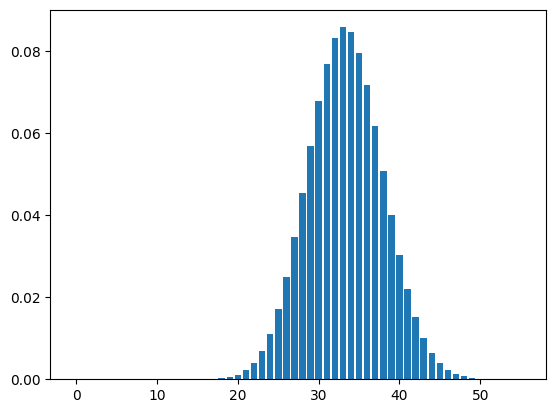

Median: 33.0
Mean: 33.351 ± 4.585 (std.dev.)
Range: [16, 50]
---
Median: 33.0
Mean: 33.301 ± 4.644 (std.dev.)
Range: [18, 52]
---
Median: 33.0
Mean: 33.265 ± 4.624 (std.dev.)
Range: [17, 54]
---


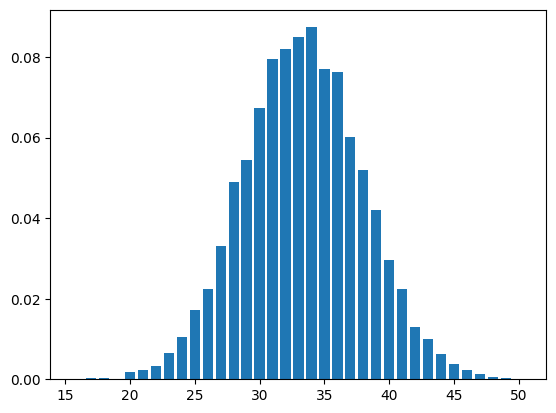

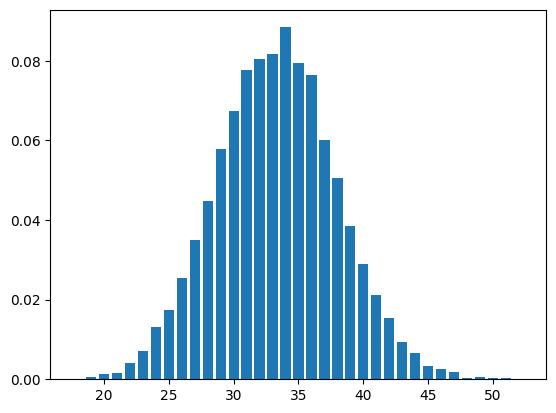

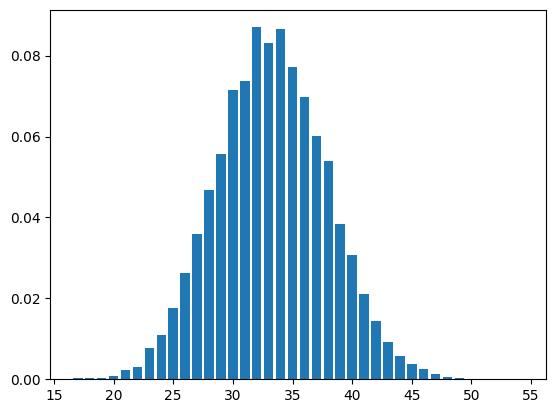

In [2]:
events = np.array([100, 100, 100, 100, 100])

cohorts = np.array([
    [1000, 1000, 1000, 1000],
    [1000, 1000, 1000, 1000],
    [1000, 1000, 1000, 1000],
])

plot_expected_pdf(
    items=cohorts[:, 1].sum(),
    num_success=cohorts[-1, 1],
    selections=events[2],
    up_to=55
)


def experiment_1a():
    return distribute(events, cohorts, event_order=[0, 1, 2, 3, 4])


def experiment_1b():
    return distribute(events, cohorts, event_order=[4, 0, 3, 1, 2])


def experiment_1c():
    return distribute(events, cohorts, event_order=[4, 3, 2, 1, 0])


run_and_compare(
    experiments=(
        compose(f, extract_last_I_to_H)
        for f in [experiment_1a, experiment_1b, experiment_1c]
    ),
    trials=10_000
)

### Experiment 2: un-even cohorts, even events

Expected ---
Mean: 0.333 ± 0.567 (std.dev.)


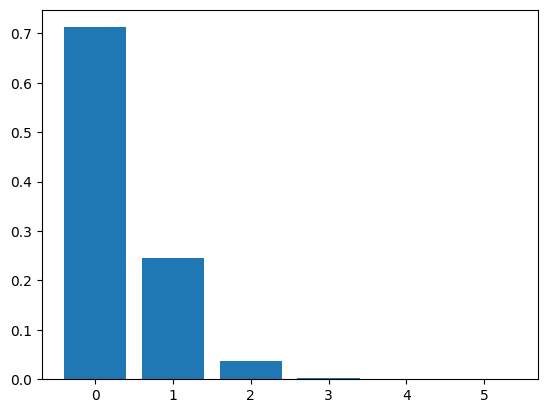

Median: 0.0
Mean: 0.328 ± 0.564 (std.dev.)
Range: [0, 4]
---
Median: 0.0
Mean: 0.331 ± 0.572 (std.dev.)
Range: [0, 3]
---
Median: 0.0
Mean: 0.344 ± 0.578 (std.dev.)
Range: [0, 5]
---


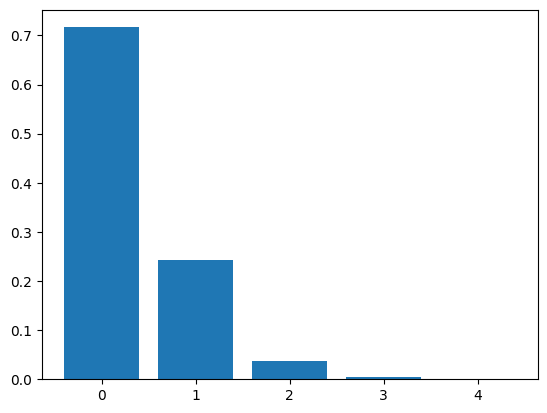

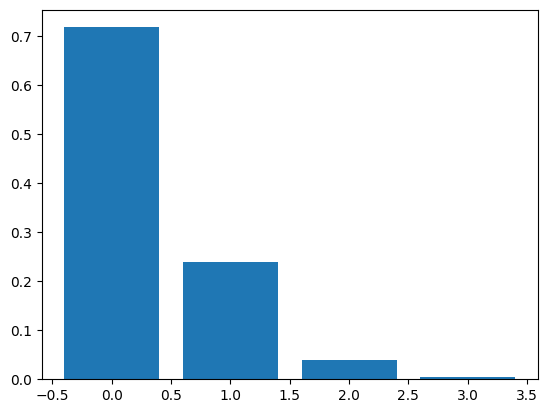

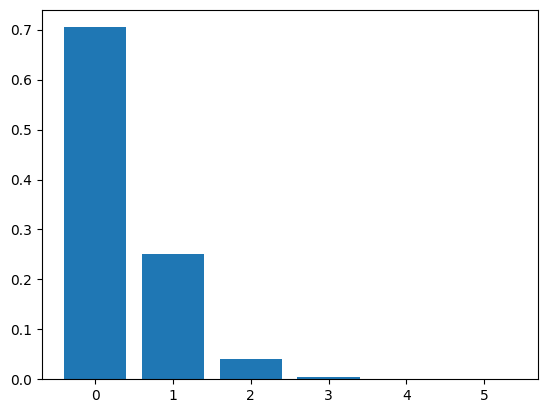

In [3]:
events = np.array([100, 100, 100, 100, 100])

cohorts = np.array([
    [2980, 2980, 2980, 2980],
    [10, 10, 10, 10],
    [10, 10, 10, 10],
])

plot_expected_pdf(
    items=cohorts[:, 1].sum(),
    num_success=cohorts[-1, 1],
    selections=events[2],
    up_to=5
)


def experiment_2a():
    return distribute(events, cohorts, event_order=[0, 1, 2, 3, 4])


def experiment_2b():
    return distribute(events, cohorts, event_order=[4, 0, 3, 1, 2])


def experiment_2c():
    return distribute(events, cohorts, event_order=[4, 3, 2, 1, 0])


run_and_compare(
    experiments=(
        compose(f, extract_last_I_to_H)
        for f in [experiment_2a, experiment_2b, experiment_2c]
    ),
    trials=10_000
)

### Experiment 3: uneven cohorts, uneven events

Expected ---
Mean: 0.033 ± 0.182 (std.dev.)


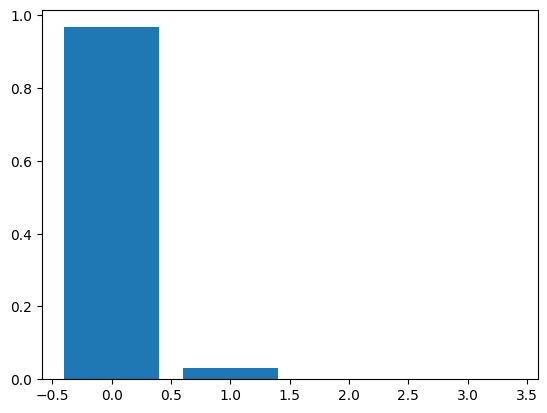

Median: 0.0
Mean: 0.037 ± 0.191 (std.dev.)
Range: [0, 2]
---
Median: 0.0
Mean: 0.035 ± 0.190 (std.dev.)
Range: [0, 2]
---
Median: 0.0
Mean: 0.033 ± 0.181 (std.dev.)
Range: [0, 2]
---


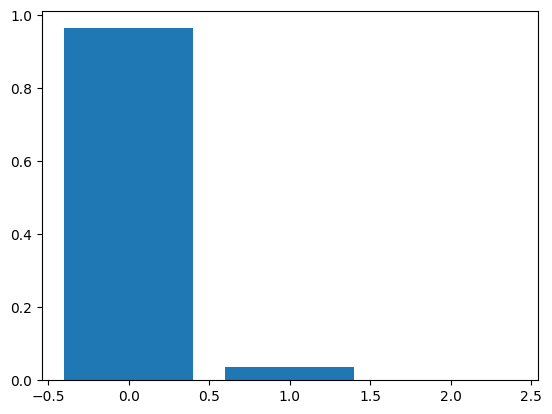

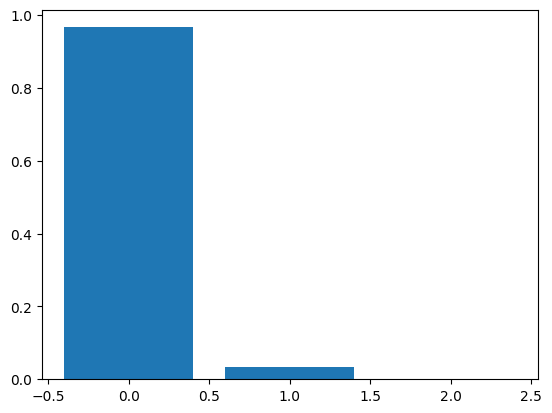

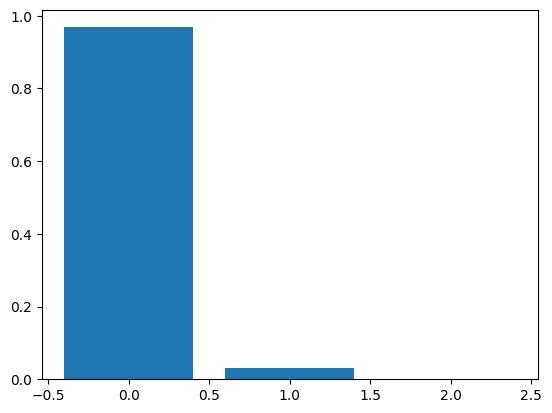

In [4]:
events = np.array([100000, 100000, 100, 100000, 100000])

cohorts = np.array([
    [300000, 300000, 300000, 300000],
    [100, 100, 100, 100],
    [100, 100, 100, 100],
])

plot_expected_pdf(
    items=cohorts[:, 1].sum(),
    num_success=cohorts[-1, 1],
    selections=events[2],
    up_to=3
)


def experiment_3a():
    return distribute(events, cohorts, event_order=[0, 1, 2, 3, 4])


def experiment_3b():
    return distribute(events, cohorts, event_order=[4, 0, 3, 1, 2])


def experiment_3c():
    return distribute(events, cohorts, event_order=[4, 3, 2, 1, 0])


run_and_compare(
    experiments=(
        compose(f, extract_last_I_to_H)
        for f in [experiment_3a, experiment_3b, experiment_3c]
    ),
    trials=10_000
)

## Conclusion

These results strongly suggest that the order in which we process events does not matter!